In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg
from scipy.optimize import minimize
from scipy.stats import norm
np.random.seed(20180903)
plt.style.use("ggplot")

#### 1. Kalman Filter Class 정의

In [21]:
class KalmanFilter:
    def __init__(self, A, B, Q, H, G, R):
        self.A = A
        self.B = B
        self.Q = Q
        self.H = H
        self.G = G # 그냥 넣어봄
        self.R = R
    
    def Predict(self, inputs):
        x, P = inputs
        x_pred = np.dot(self.A,x)+self.B
        P_pred = np.dot(np.dot(self.A,P),self.A.T) + self.Q
        return x_pred, P_pred
    
    def Update(self, update, z_meas):
        x_pred, P_pred = update
        z_pred = np.dot(self.H, x_pred) + self.G
        v = z_meas.reshape(-1,1) - z_pred
        F = np.dot(np.dot(self.H, P_pred),self.H.T) + self.R
        K = np.dot(np.dot(P_pred, self.H.T), linalg.inv(F))
        x_update = x_pred + np.dot(K, v)
        P_update = P_pred - np.dot(np.dot(K, self.H), P_pred)
        dF = linalg.det(F)
        if dF <= 0:
            print('Warning : dF <= 0 인 경우가 있습니다.')
            dF = 1e-70
        logL = -0.5*np.log(2*np.pi) - 0.5*np.log(dF) - 0.5* np.dot(v.T, np.dot(linalg.inv(F), v))
        # -logL를 minimize 해야 함
        return x_update, P_update, -logL[0][0]

#### 2. 데이터 입력

In [3]:
data = np.array(pd.read_csv('./data/KIS_spot_continuous_montly_201612.csv'))

In [111]:
# System
def set_param(param, model="DNS"):
        dt = 1/12
        tau = [0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 5, 7, 10, 15, 20]
        
        if model == "DNS":
            
            lambda_, eps, a1, a2, a3, mu1, mu2, mu3, q1, q2, q3 = param
            
            # 상태 입력
            A = np.array([[a1, 0, 0],
                          [0, a2, 0],
                          [0, 0, a3]])
            B = np.array([[(1-a1)*mu1],
                          [(1-a2)*mu2],
                          [(1-a3)*mu3]])
            Q = np.array([[q1**2, 0, 0],
                          [0, q2**2, 0],
                          [0, 0, q3**2]])
            H = np.array([[1, (1-np.exp(-lambda_*t))/(lambda_*t), (1-np.exp(-lambda_*t))/(lambda_*t)-np.exp(-lambda_*t)] for t in tau])
            G = np.zeros(len(tau)).reshape(-1,1)
            R = np.identity(len(tau))*eps**2
            
            return A, B, Q, H, G, R
        
        elif model == "AFNS":
            
            lambda_, eps, k1, k2, k3, mu1, mu2, mu3, s1, s2, s3 = param
            
            # 상태 입력
            A = np.array([[np.exp(-k1*dt), 0, 0],
                          [0, np.exp(-k2*dt), 0],
                          [0, 0, np.exp(-k3*dt)]])
            B = np.array([[(1-np.exp(-k1*dt))*mu1],
                          [(1-np.exp(-k2*dt))*mu2],
                          [(1-np.exp(-k3*dt))*mu3]])
            Q = np.array([[s1**2/(2*k1)*(1-np.exp(-2*k1*dt)), 0, 0],
                          [0, s2**2/(2*k2)*(1-np.exp(-2*k2*dt)), 0],
                          [0, 0, s3**2/(2*k3)*(1-np.exp(-2*k3*dt))]])
            H = np.array([[1, (1-np.exp(-lambda_*t))/(lambda_*t), (1-np.exp(-lambda_*t))/(lambda_*t)-np.exp(-lambda_*t)] for t in tau])
            R = np.identity(len(tau))*eps**2
            
            # Yield-adjustment Term
            A_bar = s1**2
            B_bar = s2**2
            C_bar = s3**2
            G = -1*np.array([A_bar*t**2/6 + B_bar*(1/(2*lambda_**2)-(1-np.exp(-lambda_*t))/(lambda_**3*t)+1/(4*lambda_**3*t)*(1-np.exp(-2*lambda_*t))) + C_bar*(1/(2*lambda_**2) + np.exp(-lambda_*t)/lambda_**2 -t/(4*lambda_)*np.exp(-2*lambda_*t) - 3/(4*lambda_**2)*np.exp(-2*lambda_*t) - 2/lambda_**3*(1-np.exp(-lambda_*t))/t + 5/(8*lambda_**3)*(1-np.exp(-2*lambda_*t))/t) for t in tau]).reshape(-1,1)

            return A, B, Q, H, G, R
            
        else:
            return None

In [112]:
def get_states(kf, data):
    # Input Initial State
    x0 = np.array([0.00,0.045,0.12]).reshape(-1,1)
    P0 = np.identity(3)*10
    
    n = data.shape[0]
    states = np.zeros([n+1,3])
    states[0] = x0.reshape(3)
    
    for i in range(n):
        x1, P1 = kf.Predict([x0, P0])
        x0, P0, ll = kf.Update([x1, P1], data[i,:])
        states[i+1] = x0.reshape(3)
    return states

In [113]:
def get_loglik(kf, data):
    # Input Initial State
    x0 = np.array([0.00,0.045,0.12]).reshape(-1,1)
    P0 = np.identity(3)*10
    
    n = data.shape[0]
    loglik = np.zeros(n)
    
    for i in range(n):
        x1, P1 = kf.Predict([x0, P0])
        x0, P0, ll = kf.Update([x1, P1], data[i,:])
        loglik[i] = ll
    return loglik.sum()

In [142]:
def obj(param, model):
    A,B,Q,H,G,R = set_param(param, model)
    kf = KalmanFilter(A,B,Q,H,G,R)
    res = get_loglik(kf,data)
    if np.random.randint(500) == 0:
        print('Loglikelihood is... : {}'.format(-res))
    return res

#### 3. DNS 모형

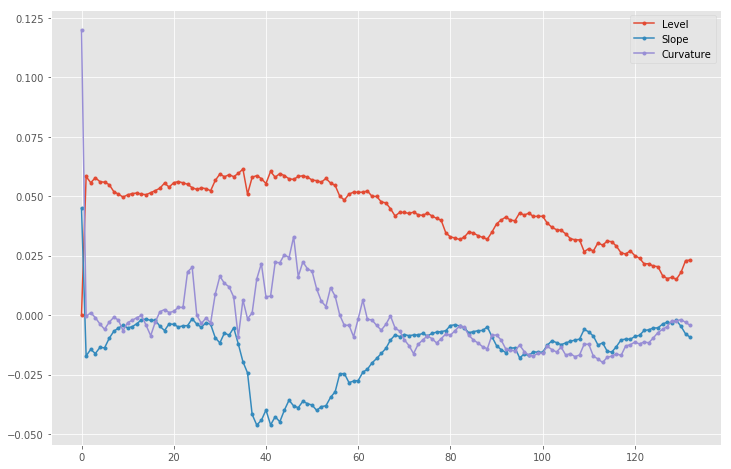

In [165]:
# DNS 모형
#lambda_, eps, a1, a2, a3, mu1, mu2, mu3, q1, q2, q3
param = [0.06040, 1e-2, 0.9827, 0.9778, 0.9189, 0.06958, -0.02487, -0.01075, 0.002485, 0.003329, 0.007471]
A, B, Q, H, G, R = set_param(res.x, model="DNS")
kf = KalmanFilter(A, B, Q, H, G, R)
states1 = get_states(kf, data)

plt.figure(figsize=(12,8))
plt.plot(states1[:,0], ".-", label="Level")
plt.plot(states1[:,1], ".-", label="Slope")
plt.plot(states1[:,2], ".-", label="Curvature")
plt.legend()
plt.show()

#### 4. AFNS 모형

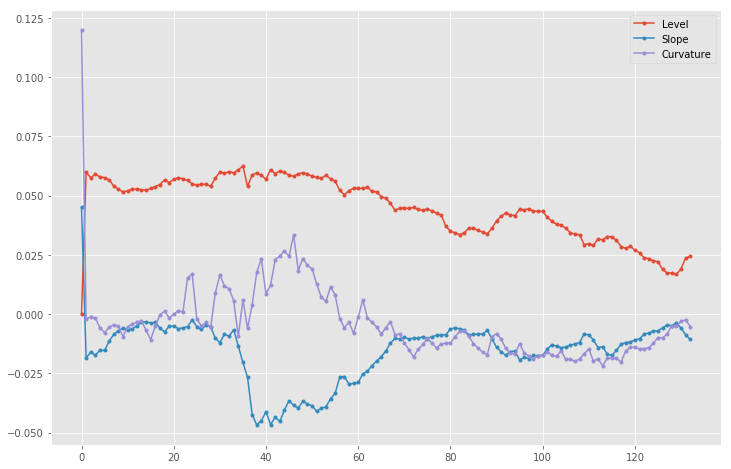

In [166]:
# AFNS 모형
#lambda_, eps, k1, k2, k3, mu1, mu2, mu3, s1, s2, s3
param = [0.5971, 1e-2, 0.06734, 0.2083, 1.230, 0.07243, -0.02825, -0.009266, 0.005095, 0.01103, 0.02647]
A, B, Q, H, G, R = set_param(res2.x, model="AFNS")
kf = KalmanFilter(A, B, Q, H, G, R)
states2 = get_states(kf, data)

plt.figure(figsize=(12,8))
plt.plot(states2[:,0], ".-", label="Level")
plt.plot(states2[:,1], ".-", label="Slope")
plt.plot(states2[:,2], ".-", label="Curvature")
plt.legend()
plt.show()

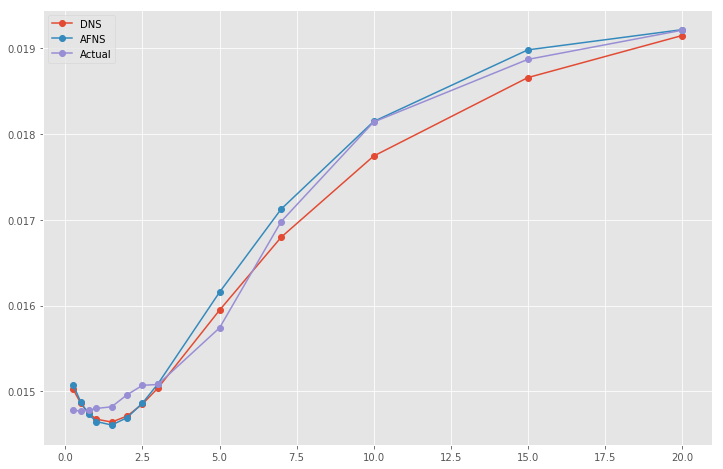

In [192]:
plt.figure(figsize=(12,8))
i = 9
tau = [0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 5, 7, 10, 15, 20]
plt.plot(tau, np.matmul(H, states1[-i,].reshape(-1,1)), "-o",label='DNS')
plt.plot(tau, np.matmul(H, states2[-i,].reshape(-1,1)) + G, "-o", label='AFNS')
plt.plot(tau, data[-i], "-o", label='Actual')
plt.legend()
plt.show()

#### 3. 최적화

In [161]:
# Optimization
#1. DNS
#   param = [0.06040, 1e-2, 0.9827, 0.9778, 0.9189, 0.06958, -0.02487, -0.01075, 0.002485, 0.003329, 0.007471]
res = minimize(fun=obj, args=("DNS"), x0=res.x, method='nelder-mead', options={'disp': True, 'maxiter':1000})

#2. AFNS
#   param = [0.5971, 1e-2, 0.06734, 0.2083, 1.230, 0.07243, -0.02825, -0.009266, 0.005095, 0.01103, 0.02647]
res2 = minimize(fun=obj, args=("AFNS"), x0=res2.x, method='nelder-mead', options={'disp': True, 'maxiter':1000})

Loglikelihood is... : 11230.521046617796
Loglikelihood is... : 11232.680668079893
Loglikelihood is... : 11232.988847468336
Loglikelihood is... : 11243.294952607685
Loglikelihood is... : 11075.043271584049
Loglikelihood is... : 11075.060857880177
Optimization terminated successfully.
         Current function value: -11075.107090
         Iterations: 688
         Function evaluations: 1423


#### 4. 시각화

In [9]:
# 상태 입력
dt = 1/12
lambda_, eps, kappa1, kappa2, kappa3, theta1, theta2, theta3, sigma1, sigma2, sigma3, rho12, rho13, rho23 = res.x
A,B,Q,H,R = set_param(param)
kf = KalmanFilter(A,B,Q,H,R)
states = get_states(kf, data)
tau = [0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 5, 7, 10, 15, 20]
H = np.array([[1, (1-np.exp(-lambda_*t))/(lambda_*t), (1-np.exp(-lambda_*t))/(lambda_*t)-np.exp(-lambda_*t)] for t in tau])

kappa = np.array([kappa1,kappa2,kappa3]).reshape(-1,1)
theta = np.array([theta1,theta2,theta3]).reshape(-1,1)
Q = np.array([[sigma1**2, sigma1*sigma2*rho12, sigma1*sigma3*rho13],
              [sigma1*sigma2*rho12, sigma2**2, sigma2*sigma3*rho23],
              [sigma1*sigma3*rho13, sigma2*sigma3*rho23, sigma3**2]])
S = linalg.cholesky(Q)

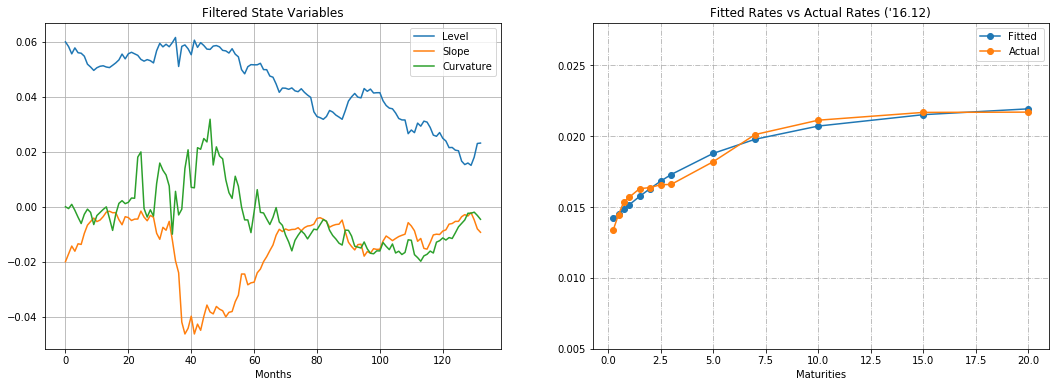

In [10]:
# Visualization
fig, ax = plt.subplots(1,2, figsize=(18,6))

# Filtered State Variables
titles = ['Level', 'Slope', 'Curvature']
for i in range(3):
    ax[0].plot(states[:,i], label=titles[i])
ax[0].set_xlabel('Months')
ax[0].set_title('Filtered State Variables')
ax[0].grid()
ax[0].legend()

i = -1
# Fitted Rates vs Actual Rates
# 2006년 1월 = 0, 2006년 2월 = 1 ...
ax[1].plot(tau, np.dot(H, states[i]), '-o', label='Fitted')
ax[1].plot(tau, data[i,], '-o', label='Actual')
ax[1].set_xlabel('Maturities')
ax[1].legend()
ax[1].set_title('Fitted Rates vs Actual Rates (\'16.12)')
ax[1].grid(True, linestyle='-.')
ax[1].set_ylim([0.005,0.028])

plt.show()